In [212]:
import os.path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from gensim.downloader import load
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist #used to determine number of tokens
from gensim.models import Word2Vec

In [213]:
with open("goemotions.json", "r") as read_content:
    file = pd.read_json(read_content)

Taking count of all sentiment and emotion tags respectively associated with Reddit posts. Then creating a dictionary to create key-value pairings.

In [214]:
print(file.loc[file[0]=='They have THE BEST tortillas too. Made right in front of you. Mmmmmm!'])

                                                        0           1  \
264     They have THE BEST tortillas too. Made right i...     neutral   
23540   They have THE BEST tortillas too. Made right i...     neutral   
73369   They have THE BEST tortillas too. Made right i...  admiration   
86008   They have THE BEST tortillas too. Made right i...  admiration   
115605  They have THE BEST tortillas too. Made right i...    approval   

               2  
264      neutral  
23540    neutral  
73369   positive  
86008   positive  
115605  positive  


In [215]:
sentiment = file[2].value_counts().to_dict()
sentiment_values = sentiment.keys()
sentiment_frequency = sentiment.values()

In [216]:
emotion = file[1].value_counts().to_dict()
emotion_values = emotion.keys()
emotion_frequency = emotion.values()

In [217]:
# print(emotion)
# emotion_list = list(emotion_frequency)
# pdP = pd.Series(emotion_list)
# print(pdP.describe())

In [218]:
# print(sentiment)
# sentiment_list = list(sentiment_frequency)
# pdP = pd.Series(sentiment_list) 
# print(pdP.describe())

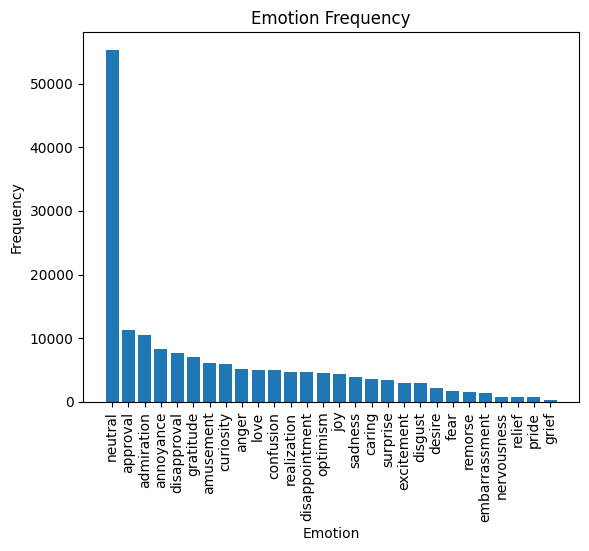

In [219]:
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.title("Emotion Frequency")
plt.xticks(rotation= 90) #done for readbility purposes
plt.bar(emotion_values, emotion_frequency)
plt.savefig("bar_emotion.png")
plt.show()

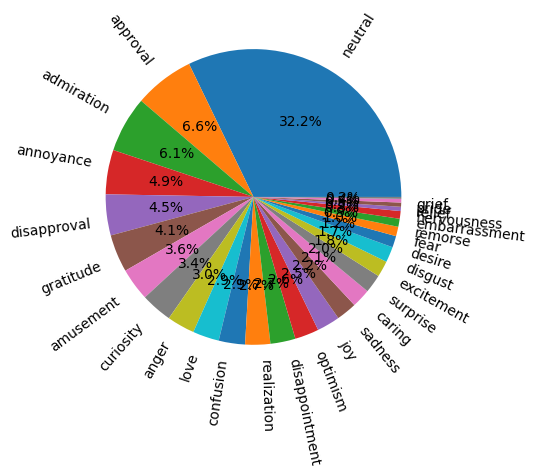

In [220]:
emotionLabels = []
sizes = []
for x, y in emotion.items():
    emotionLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=emotionLabels, rotatelabels = True, autopct ='%1.1f%%')
plt.savefig("pie_emotion.png")
plt.show()


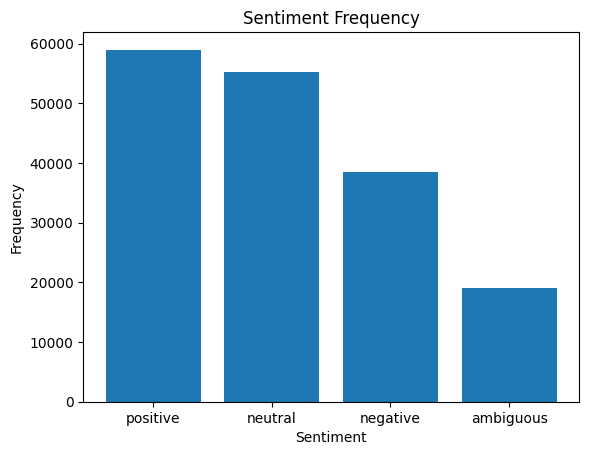

In [221]:
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Sentiment Frequency")
plt.bar(sentiment_values, sentiment_frequency)
plt.savefig("bar_sentiment.png")
plt.show()

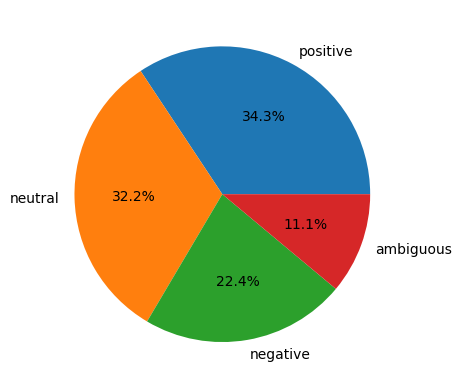

In [222]:
sentimentLabels = []
sizes = []
for x, y in sentiment.items():
    sentimentLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=sentimentLabels, autopct ='%1.1f%%')
plt.savefig("pie_sentiment.png")
plt.show()


Plotting of Frequency vs. Emotion and Frequency vs. Sentiment <br>
Source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html

<h1>extract tokens/words</h1>

In [223]:
post = file[0].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(post)
# vectorizer.get_feature_names_out()

In [224]:
# print(f"The number of unique words is {len(X.toarray()[0])} unique words")

Given that when X.toarray() is used, the occurrences of words in a post is counted for example <br> "This document is the second document."<br> the word document is used twice [0 2 0 1 0 1 1 0 1] mapping to the array of unique words ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
<br>
Sources: <br>
https://stackoverflow.com/questions/27488446/how-do-i-get-word-frequency-in-a-corpus-using-scikit-learn-countvectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [225]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1]) #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2]) #change 0 to the column of sentiment with no separation

<h2>2.2 Training and Test data split</h2>

In [226]:
#Question 2.2
X_train,X_test,yemo_train, yemo_test,ysent_train, ysent_test = train_test_split(X,encodedEmo,encodedSentiment, test_size = 0.2, train_size=0.8)

In [227]:
def metrics(true_y,prediction_y):
    print(f"Accuracy for Emotion: {accuracy_score(y_true=true_y,y_pred= prediction_y)}")
    print(f"Precision (Weighted) for Emotion: {precision_score(y_true=true_y,y_pred= prediction_y, average='weighted')}")
    print(f"F1 Score (Weighted) for Emotion: {f1_score(y_true=true_y,y_pred= prediction_y,average='weighted')}")
    print(f"F1 Score (Macro) for Emotion: {f1_score(y_true=true_y,y_pred= prediction_y,average='macro')}")
    print(classification_report(y_true=true_y,y_pred= prediction_y, zero_division='warn'))
    confusion_matrix(y_true=true_y,y_pred= prediction_y)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html)
with the default parameters.</h2>

Source: https://www.delftstack.com/howto/python/how-to-get-dictionary-keys-as-a-list-in-python/

In [228]:
classifier = MultinomialNB()
if (os.path.exists('models/MNB1_model.pickle')):
    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2_model.pickle')):
    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

Score for Emotion: 0.43542660924223026
Accuracy for Emotion: 0.43542660924223026
Precision (Weighted) for Emotion: 0.4796332863631978
F1 Score (Weighted) for Emotion: 0.36819448116991255
F1 Score (Macro) for Emotion: 0.22323466411049217
              precision    recall  f1-score   support

           0       0.55      0.51      0.53      2133
           1       0.63      0.37      0.47      1210
           2       0.53      0.19      0.28      1062
           3       0.38      0.13      0.20      1635
           4       0.44      0.17      0.24      2310
           5       0.50      0.11      0.19       666
           6       0.56      0.10      0.17      1000
           7       0.55      0.17      0.26      1187
           8       0.56      0.05      0.09       402
           9       0.52      0.09      0.15       951
          10       0.45      0.15      0.22      1533
          11       0.54      0.10      0.17       586
          12       0.75      0.02      0.04       296
      

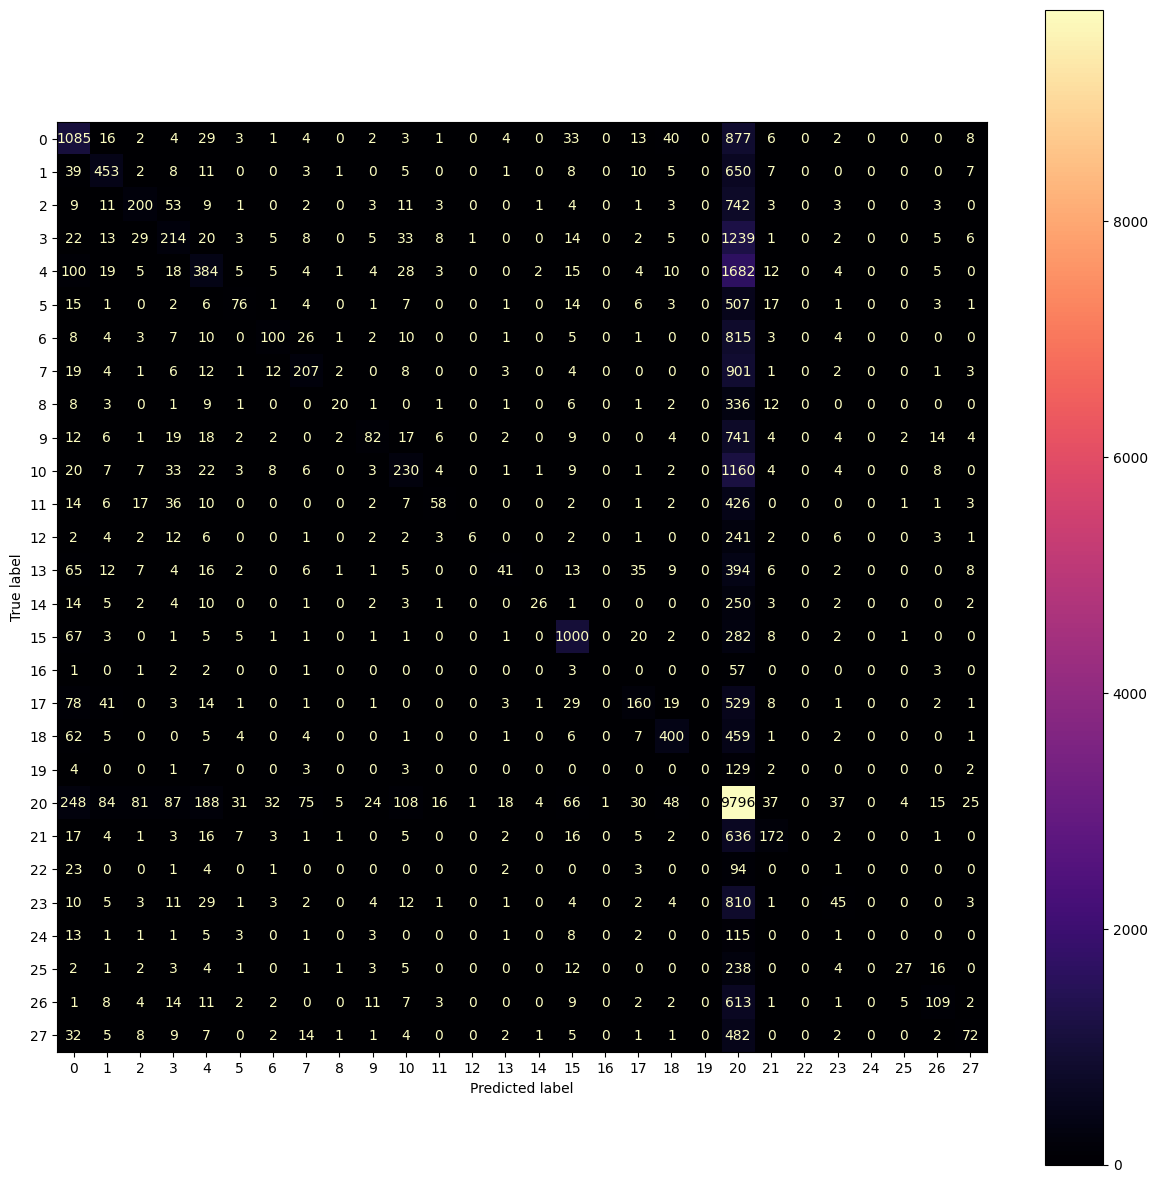

In [229]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.6051390990571528
Accuracy for Emotion: 0.6051390990571528
Precision (Weighted) for Emotion: 0.5997443683350895
F1 Score (Weighted) for Emotion: 0.5984173366191204
F1 Score (Macro) for Emotion: 0.5646064284258688
              precision    recall  f1-score   support

           0       0.54      0.32      0.40      3789
           1       0.61      0.60      0.60      7737
           2       0.56      0.56      0.56     11061
           3       0.66      0.75      0.70     11777

    accuracy                           0.61     34364
   macro avg       0.59      0.56      0.56     34364
weighted avg       0.60      0.61      0.60     34364



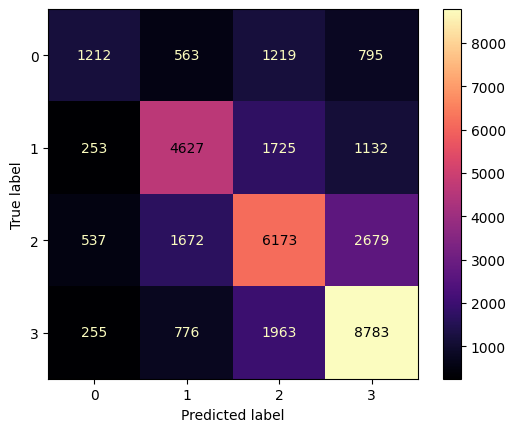

In [230]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>cross validation</h2>
<body>from sklearn.model_selection import cross_val_score</body>

<h2>Decision Tree (tree.DecisionTreeClassifier) with the default parameters.</h2>

In [231]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/DT1_model.pickle')):
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)


if (os.path.exists('models/DT2_model.pickle')):

    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotion: 0.5918693982074263
Accuracy for Emotion: 0.5918693982074263
Precision (Weighted) for Emotion: 0.6070236290097285
F1 Score (Weighted) for Emotion: 0.5883853595397149
F1 Score (Macro) for Emotion: 0.51396487764524
              precision    recall  f1-score   support

           0       0.58      0.81      0.68      2133
           1       0.59      0.82      0.68      1210
           2       0.45      0.71      0.55      1062
           3       0.41      0.59      0.48      1635
           4       0.45      0.56      0.50      2310
           5       0.49      0.56      0.53       666
           6       0.46      0.56      0.51      1000
           7       0.57      0.60      0.58      1187
           8       0.49      0.54      0.51       402
           9       0.45      0.45      0.45       951
          10       0.53      0.47      0.50      1533
          11       0.51      0.38      0.44       586
          12       0.50      0.40      0.44       296
          13

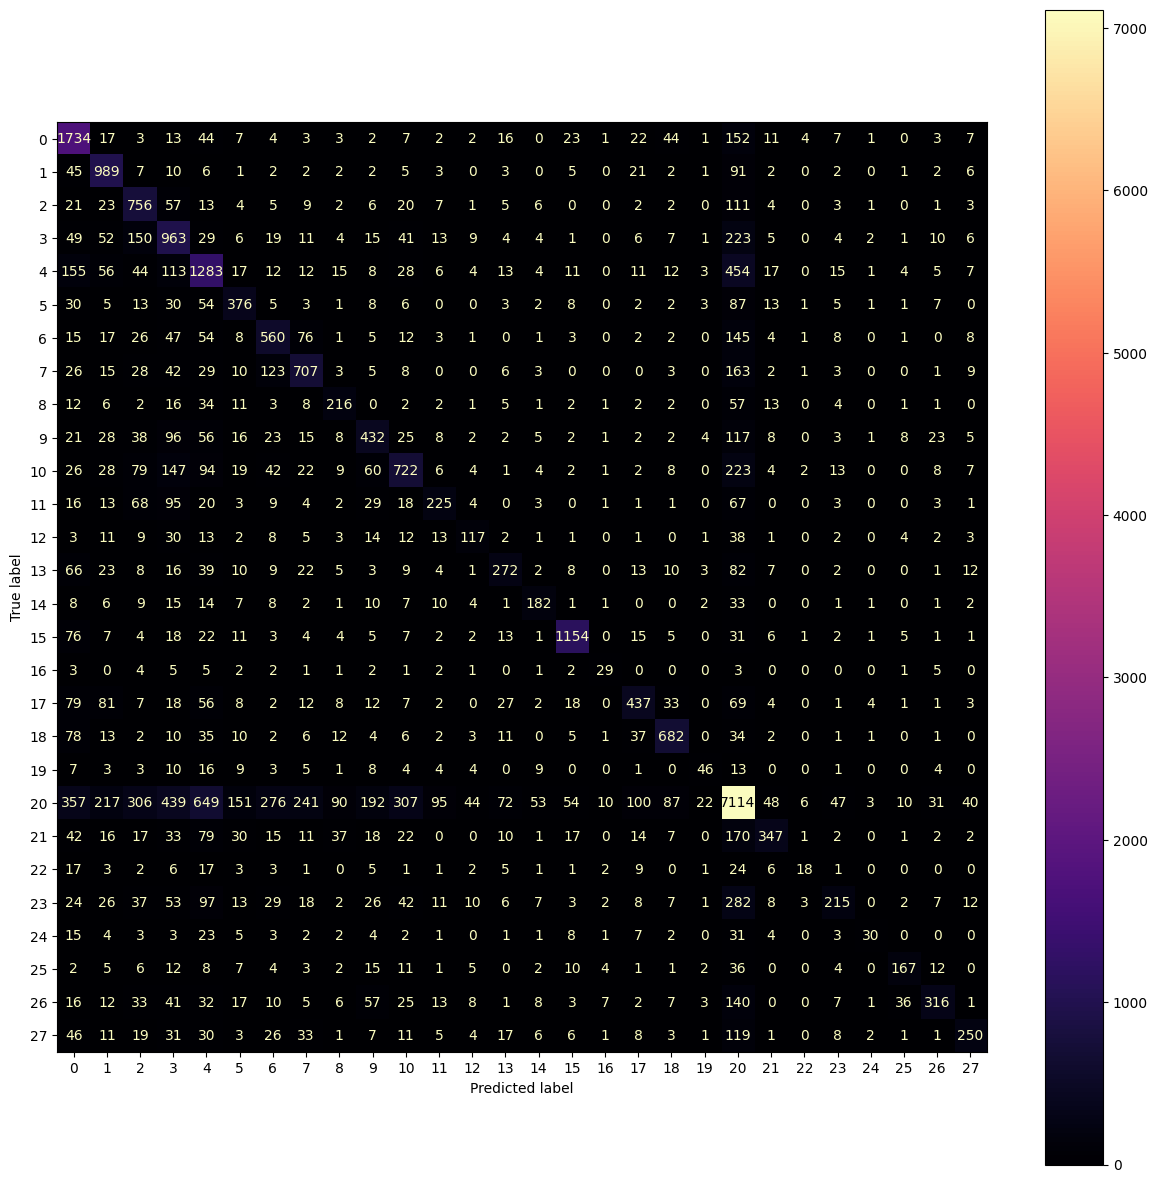

In [232]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')


Score for Sentiment: 0.7142940286346177
Accuracy for Emotion: 0.7142940286346177
Precision (Weighted) for Emotion: 0.7260036219691919
F1 Score (Weighted) for Emotion: 0.7166673458219663
F1 Score (Macro) for Emotion: 0.7009250102589182
              precision    recall  f1-score   support

           0       0.56      0.71      0.63      3789
           1       0.67      0.78      0.72      7737
           2       0.70      0.66      0.68     11061
           3       0.84      0.73      0.78     11777

    accuracy                           0.71     34364
   macro avg       0.69      0.72      0.70     34364
weighted avg       0.73      0.71      0.72     34364



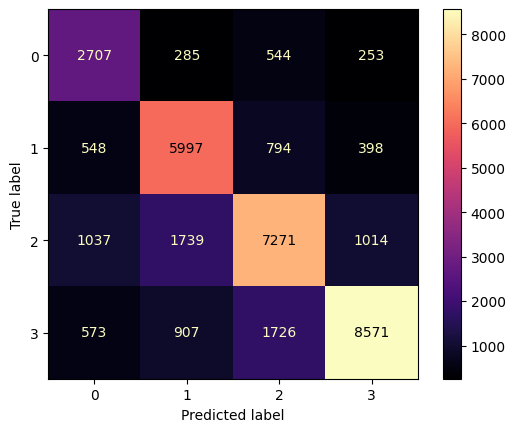

In [233]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.</h2>

In [234]:
classifier = MLPClassifier(max_iter=100)
if (os.path.exists('models/MLP1_model.pickle')):
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP1 = classifier.fit(X_train, yemo_train)
    with open('models/MLP1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MLP2_model.pickle')):
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP2 = classifier.fit(X_train,ysent_train)
    with open('models/MLP2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotion: 0.5714410429519264
Accuracy for Emotion: 0.5714410429519264
Precision (Weighted) for Emotion: 0.5646496566774261
F1 Score (Weighted) for Emotion: 0.5655606431137628
F1 Score (Macro) for Emotion: 0.4997263807846279
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      2133
           1       0.65      0.67      0.66      1210
           2       0.53      0.50      0.52      1062
           3       0.44      0.38      0.41      1635
           4       0.49      0.39      0.43      2310
           5       0.50      0.47      0.48       666
           6       0.50      0.46      0.48      1000
           7       0.56      0.48      0.52      1187
           8       0.44      0.55      0.49       402
           9       0.41      0.37      0.39       951
          10       0.48      0.48      0.48      1533
          11       0.45      0.40      0.42       586
          12       0.43      0.42      0.42       296
          

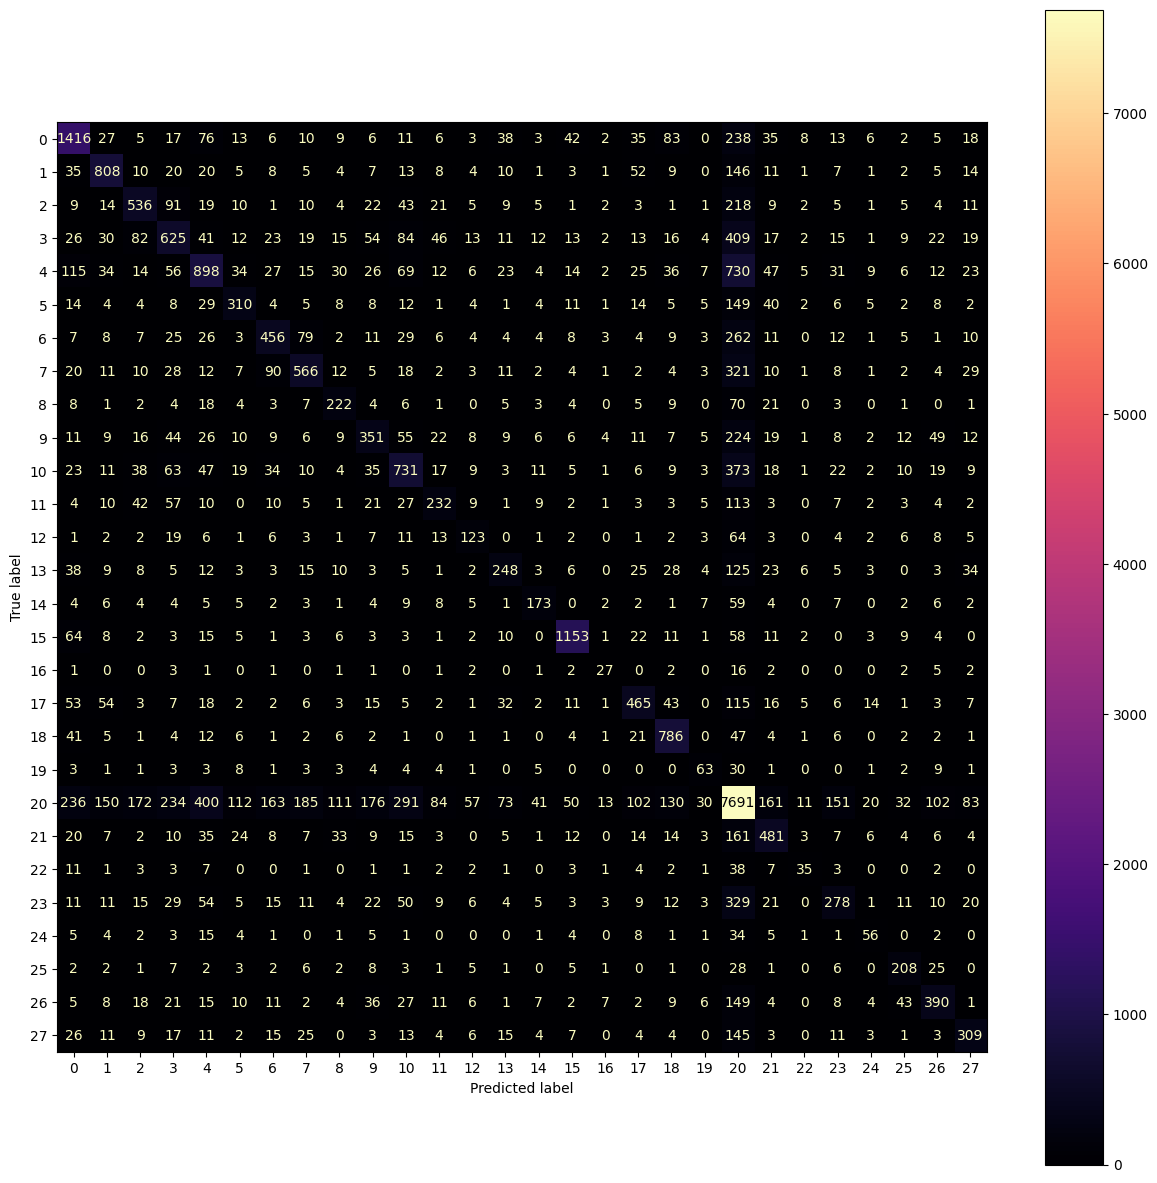

In [235]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.5586951460831102
Accuracy for Emotion: 0.5586951460831102
Precision (Weighted) for Emotion: 0.565109922262802
F1 Score (Weighted) for Emotion: 0.5434708931101527
F1 Score (Macro) for Emotion: 0.483403765008027
              precision    recall  f1-score   support

           0       0.52      0.13      0.21      3789
           1       0.57      0.46      0.51      7737
           2       0.47      0.64      0.54     11061
           3       0.67      0.69      0.68     11777

    accuracy                           0.56     34364
   macro avg       0.56      0.48      0.48     34364
weighted avg       0.57      0.56      0.54     34364



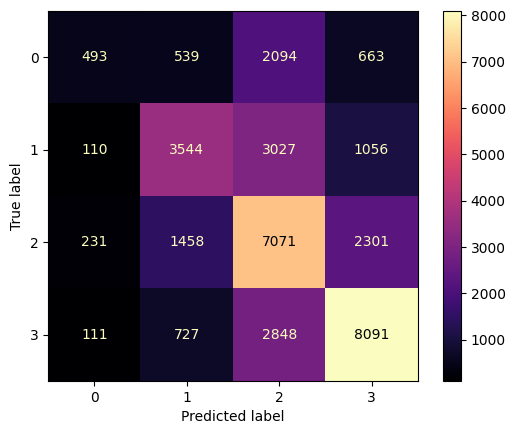

In [236]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1


In [237]:
parameters = {"alpha":(0.5,0,0.36,1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/MNB1GridCV_model.pickle')):
    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2GridCV_model.pickle')):
    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Best estimator (Emotion): MultinomialNB(alpha=0.36), Best Score: 0.3834754477508645
Accuracy for Emotion: 0.4808229542544523
Precision (Weighted) for Emotion: 0.4745312940644775
F1 Score (Weighted) for Emotion: 0.45580312038935084
F1 Score (Macro) for Emotion: 0.35680718965064806
              precision    recall  f1-score   support

           0       0.53      0.61      0.57      2133
           1       0.59      0.62      0.60      1210
           2       0.49      0.37      0.42      1062
           3       0.37      0.23      0.28      1635
           4       0.42      0.25      0.31      2310
           5       0.41      0.34      0.37       666
           6       0.43      0.26      0.33      1000
           7       0.49      0.33      0.39      1187
           8       0.54      0.25      0.34       402
           9       0.42      0.21      0.28       951
          10       0.40      0.29      0.34      1533
          11       0.48      0.25      0.33       586
          12    

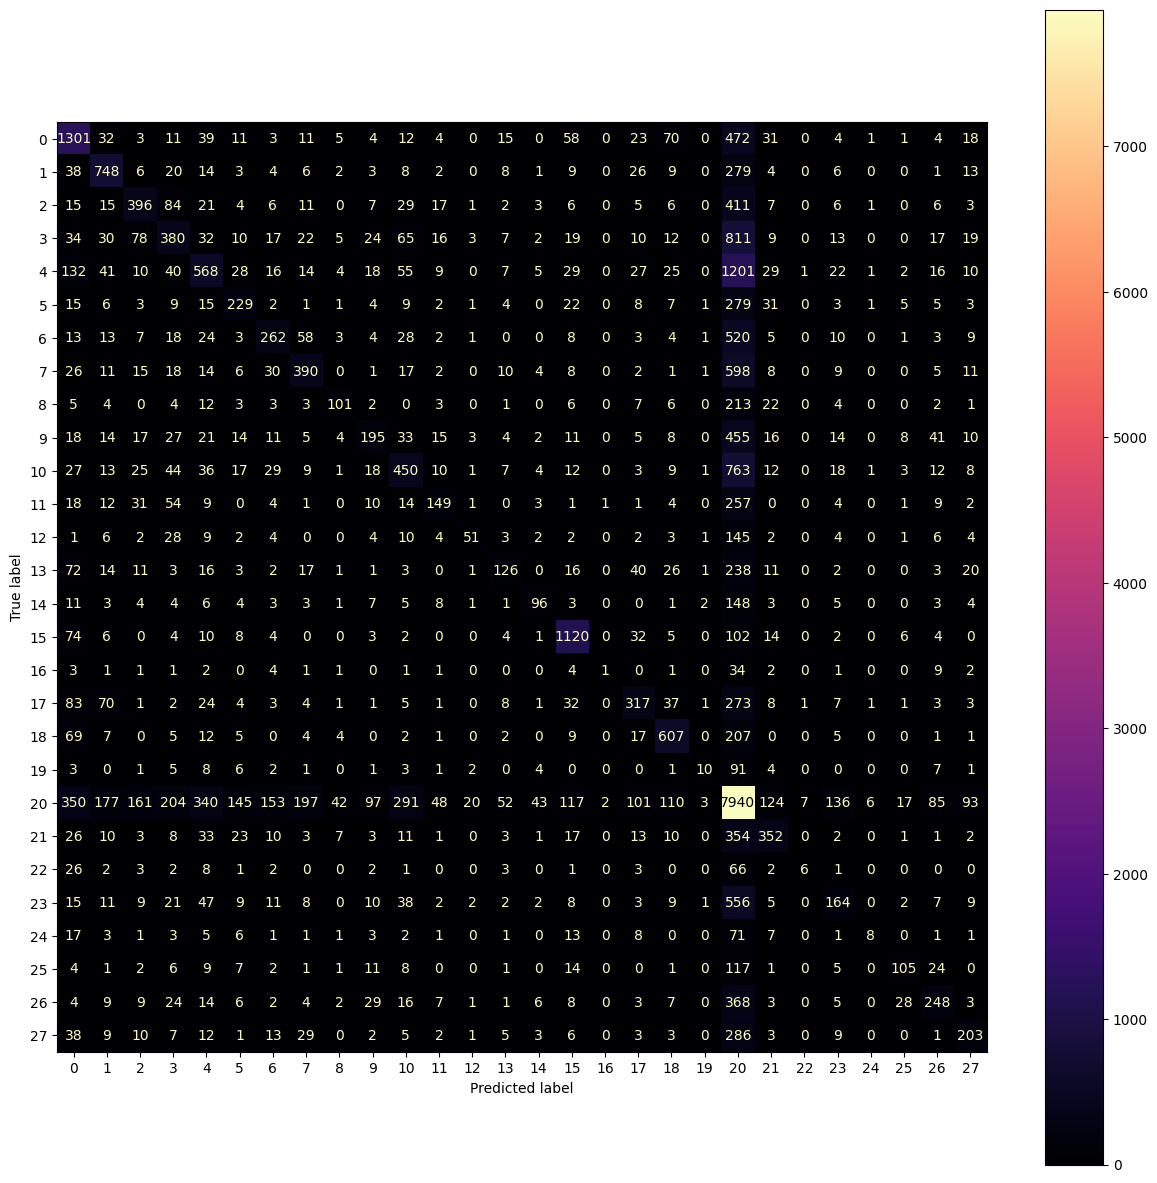

In [238]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Best estimator (Sentiment): MultinomialNB(alpha=1), Best Score: 0.5383904367141189
Accuracy for Emotion: 0.6060121056920033
Precision (Weighted) for Emotion: 0.6002119496736373
F1 Score (Weighted) for Emotion: 0.5991778251431007
F1 Score (Macro) for Emotion: 0.5647566015978657
              precision    recall  f1-score   support

           0       0.53      0.32      0.40      3789
           1       0.60      0.60      0.60      7737
           2       0.56      0.56      0.56     11061
           3       0.66      0.75      0.70     11777

    accuracy                           0.61     34364
   macro avg       0.59      0.56      0.56     34364
weighted avg       0.60      0.61      0.60     34364



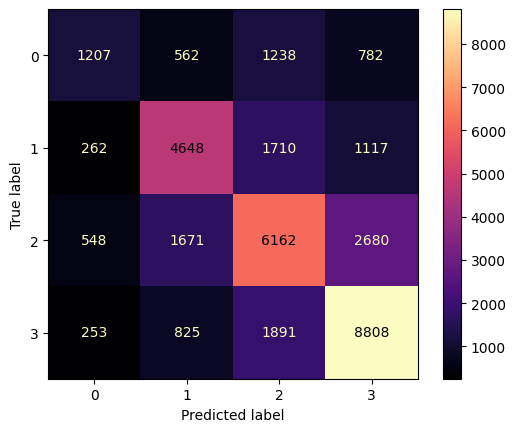

In [239]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Decision Tree Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples


In [240]:
parameters = {"criterion":("gini","entropy"),"max_depth":(100,3),"min_samples_split":(12,5,30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/DT1GridCV_model.pickle')):
    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/DT2GridCV_model.pickle')):
    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.4044639513068846
Accuracy for Emotion: 0.5012513095099522
Precision (Weighted) for Emotion: 0.5048442497728473
F1 Score (Weighted) for Emotion: 0.45999001990161503
F1 Score (Macro) for Emotion: 0.3602421444948779
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      2133
           1       0.61      0.65      0.63      1210
           2       0.50      0.35      0.41      1062
           3       0.37      0.20      0.26      1635
           4       0.41      0.19      0.26      2310
           5       0.40      0.21      0.27       666
           6       0.45      0.23      0.31      1000
           7       0.49      0.23      0.31      1187
           8       0.51      0.30      0.38       402
           9       0.44      0.16      0.24       951
          10       0.44      0.21      0.29      1533
          11       0.49      0.24    

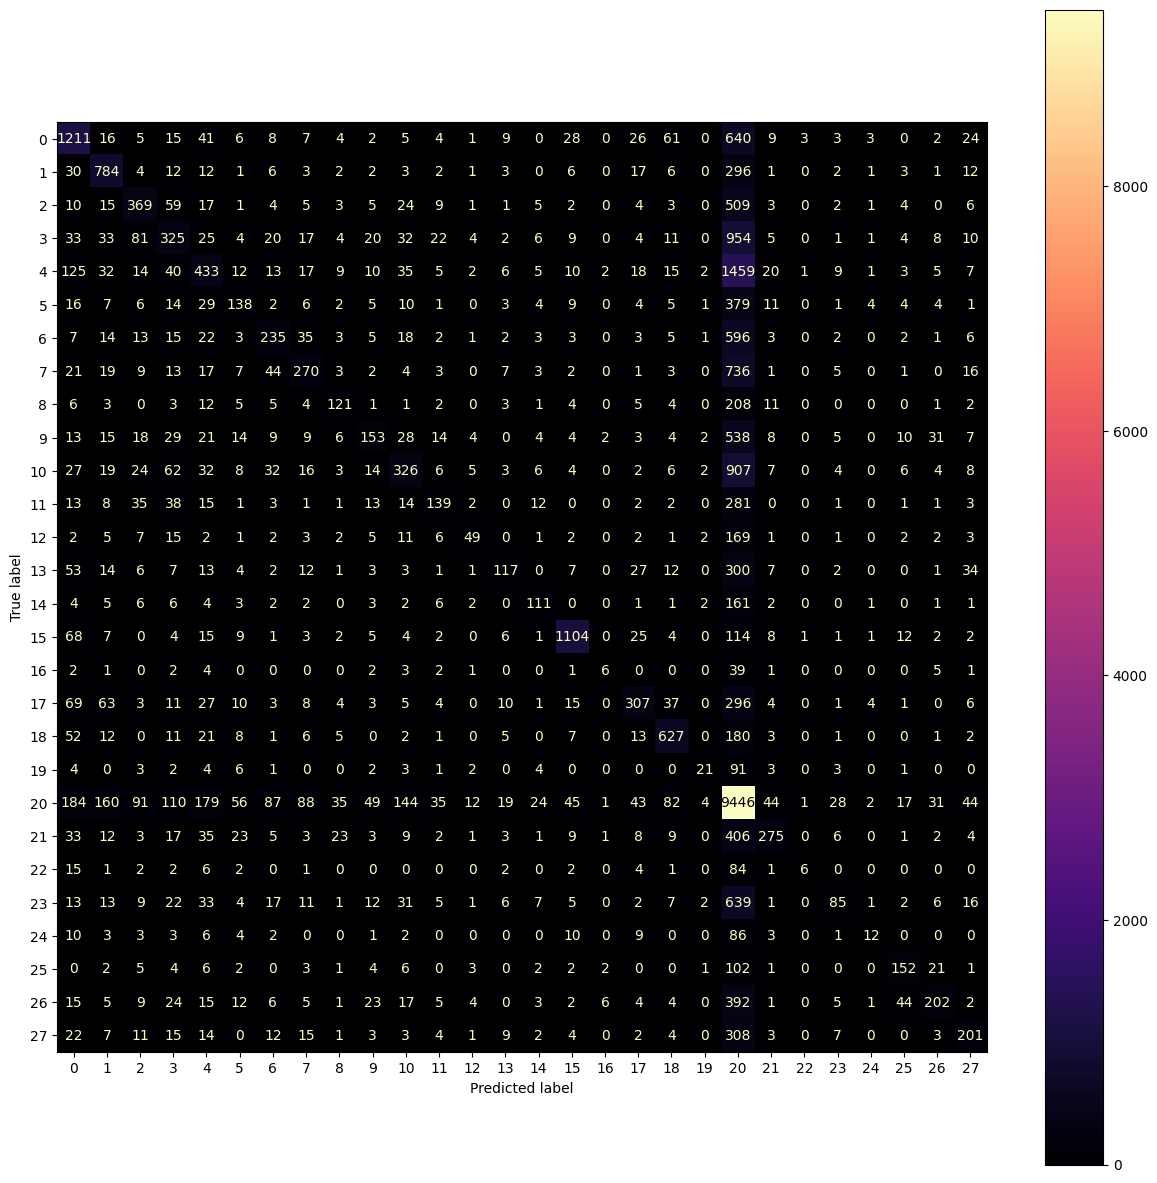

In [241]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.515219404662324
Accuracy for Emotion: 0.6168373879641486
Precision (Weighted) for Emotion: 0.6649039314847017
F1 Score (Weighted) for Emotion: 0.619041546603376
F1 Score (Macro) for Emotion: 0.5919597099545666
              precision    recall  f1-score   support

           0       0.53      0.44      0.48      3789
           1       0.69      0.50      0.58      7737
           2       0.50      0.79      0.61     11061
           3       0.84      0.59      0.70     11777

    accuracy                           0.62     34364
   macro avg       0.64      0.58      0.59     34364
weighted avg       0.66      0.62      0.62     34364



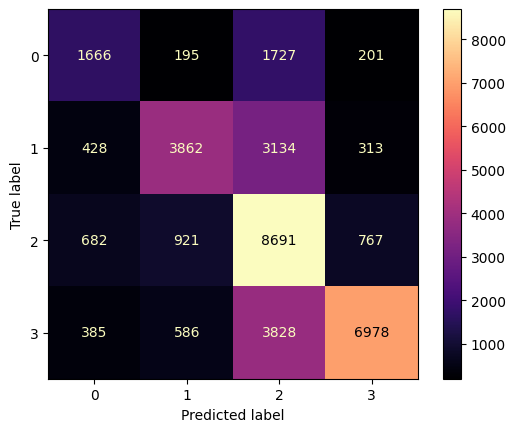

In [242]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [243]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd"),"max_iter":(5,50,100)}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier()
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters)
skip=True
if(not skip):
    if (os.path.exists('models/MLP1GridCV_model.pickle')):
        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/MLP1GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/MLP2GridCV_model.pickle')):
        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/MLP2GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

skipped


In [244]:
if (os.path.exists('models/MLP1GridCV_model.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

skipped


In [245]:
if (os.path.exists('models/MLP2GridCV_model.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

skipped


<h3>2.5</h3>
Test/Training split: 80/20 -> 95/5
Anticipated effect: increased accuracy but poor generalization


In [246]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1])  #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2])  #change 0 to the column of sentiment with no separation



In [247]:
X_train, X_test, yemo_train, yemo_test, ysent_train, ysent_test = train_test_split(X, encodedEmo, encodedSentiment,test_size=0.5, train_size=0.5)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html) using new test train split</h2>

In [248]:
classifier = MultinomialNB()
if (os.path.exists('models/new_split/MNB1_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")

else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotion: 0.45087882667908274
Accuracy for Emotion: 0.45087882667908274
Precision (Weighted) for Emotion: 0.4954413593775152
F1 Score (Weighted) for Emotion: 0.3915328895734167
F1 Score (Macro) for Emotion: 0.2507249970117103
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      5267
           1       0.62      0.42      0.50      3039
           2       0.51      0.21      0.30      2627
           3       0.43      0.17      0.25      4135
           4       0.46      0.19      0.27      5556
           5       0.44      0.13      0.20      1794
           6       0.55      0.13      0.21      2474
           7       0.55      0.18      0.28      2989
           8       0.63      0.09      0.15      1054
           9       0.53      0.10      0.17      2334
          10       0.45      0.16      0.24      3882
          11       0.58      0.14      0.23      1480
          12       0.64      0.04      0.08       690
        

C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

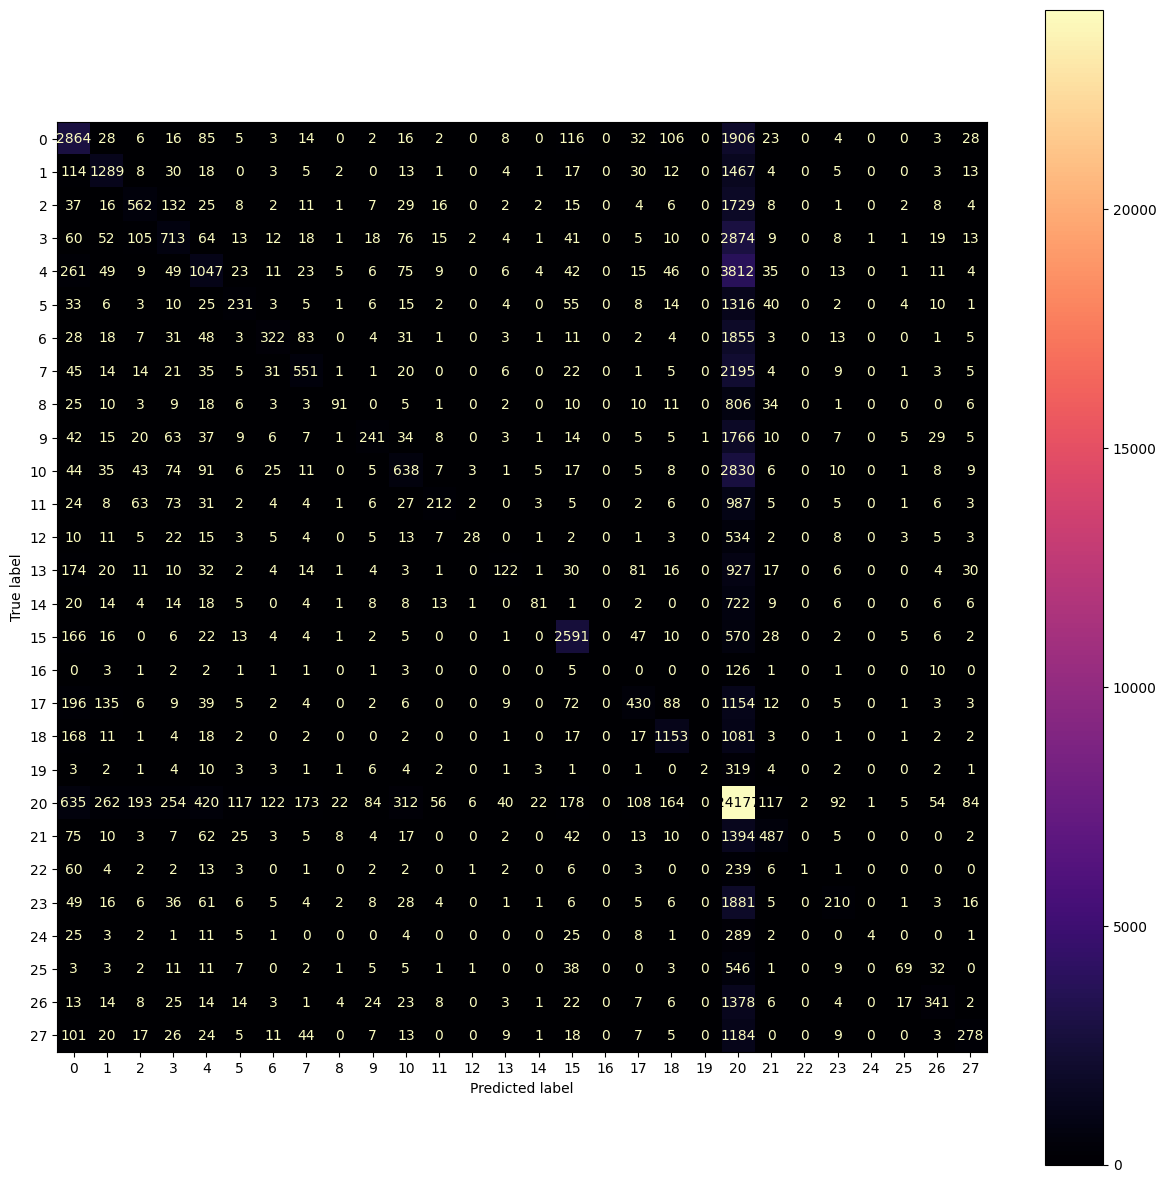

In [249]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.6149109533232453
Accuracy for Emotion: 0.6149109533232453
Precision (Weighted) for Emotion: 0.6098777888671919
F1 Score (Weighted) for Emotion: 0.6088927778965006
F1 Score (Macro) for Emotion: 0.5774810988989699
              precision    recall  f1-score   support

           0       0.55      0.35      0.42      9605
           1       0.61      0.61      0.61     19313
           2       0.57      0.57      0.57     27700
           3       0.66      0.75      0.70     29292

    accuracy                           0.61     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.61      0.61     85910



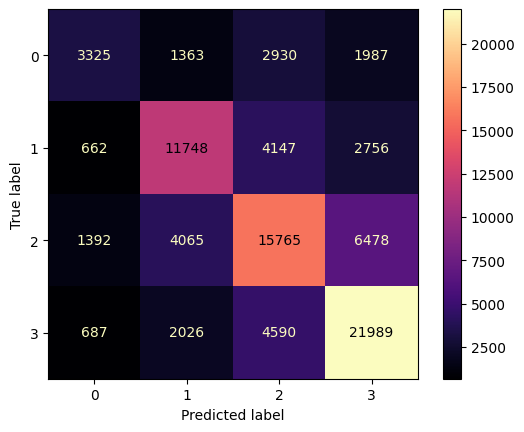

In [250]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Decision Tree (tree.DecisionTreeClassifier) using new test train split</h2>

In [251]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/new_split/DT1_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotion: 0.6206960772901874
Accuracy for Emotion: 0.6206960772901874
Precision (Weighted) for Emotion: 0.6314660864911524
F1 Score (Weighted) for Emotion: 0.6153846397330748
F1 Score (Macro) for Emotion: 0.5344461907348171
              precision    recall  f1-score   support

           0       0.59      0.83      0.69      5267
           1       0.59      0.83      0.69      3039
           2       0.48      0.70      0.57      2627
           3       0.43      0.58      0.49      4135
           4       0.48      0.55      0.51      5556
           5       0.50      0.58      0.54      1794
           6       0.52      0.56      0.54      2474
           7       0.62      0.61      0.61      2989
           8       0.52      0.52      0.52      1054
           9       0.48      0.45      0.46      2334
          10       0.57      0.49      0.53      3882
          11       0.60      0.41      0.49      1480
          12       0.58      0.39      0.47       690
          

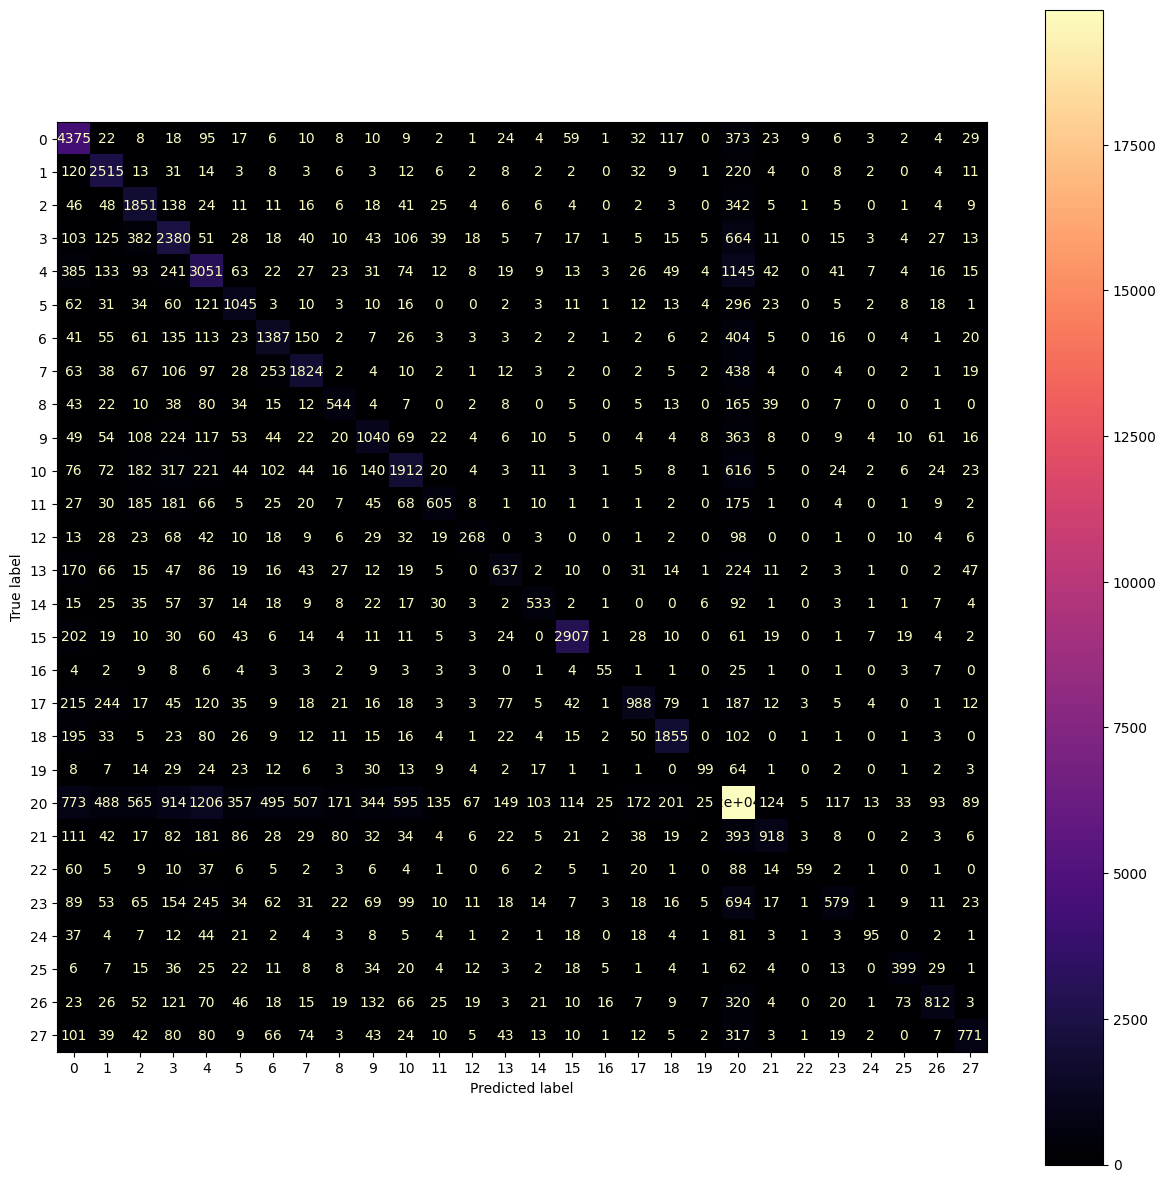

In [252]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.7402747060877662
Accuracy for Emotion: 0.7402747060877662
Precision (Weighted) for Emotion: 0.746897903400482
F1 Score (Weighted) for Emotion: 0.7418405435431122
F1 Score (Macro) for Emotion: 0.7266012381424103
              precision    recall  f1-score   support

           0       0.61      0.71      0.65      9605
           1       0.70      0.78      0.74     19313
           2       0.73      0.70      0.72     27700
           3       0.84      0.76      0.80     29292

    accuracy                           0.74     85910
   macro avg       0.72      0.74      0.73     85910
weighted avg       0.75      0.74      0.74     85910



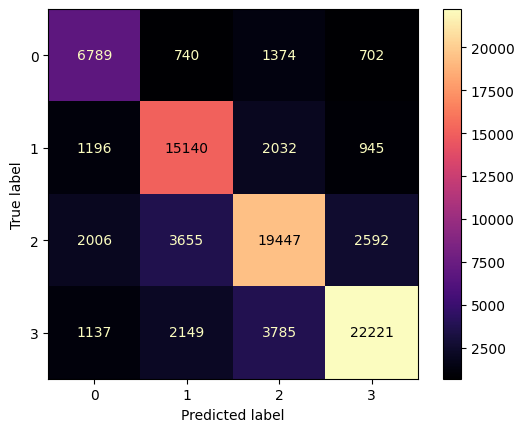

In [253]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) using new test train split</h2>

<b>Did not converge timed out</b>

In [254]:
classifier = MLPClassifier(max_iter=100)
skip=True
if(not skip):
    if (os.path.exists('models/new_split/MLP1_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP1 = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP2 = classifier.fit(X_train, ysent_train)
        with open('models/new_split/MLP2_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

skipped


In [255]:

if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.predict(X_test)
    print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
    metrics(yemo_test, y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
    fig, ax = plt.subplots(figsize=(15, 15))
    cmp.plot(ax=ax, cmap='magma')
else:
    print("skipped")

skipped


In [256]:
if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.predict(X_test)

    print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
    metrics(ysent_test, y_sent_predict)
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

skipped


<h2>Multinomial Naive Bayes Classifier found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1

In [257]:
parameters = {"alpha": (0.5, 0, 0.36, 1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/MNB1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Best estimator (Emotion): MultinomialNB(alpha=0.5), Best Score: 0.3905984755012737
Accuracy for Emotion: 0.4870445815388197
Precision (Weighted) for Emotion: 0.48912389946208057
F1 Score (Weighted) for Emotion: 0.45636533581759864
F1 Score (Macro) for Emotion: 0.34509885888873776
              precision    recall  f1-score   support

           0       0.54      0.61      0.57      5267
           1       0.60      0.59      0.59      3039
           2       0.50      0.35      0.41      2627
           3       0.41      0.25      0.31      4135
           4       0.43      0.24      0.31      5556
           5       0.39      0.28      0.32      1794
           6       0.48      0.24      0.32      2474
           7       0.51      0.31      0.38      2989
           8       0.55      0.21      0.30      1054
           9       0.45      0.19      0.26      2334
          10       0.42      0.27      0.33      3882
          11       0.51      0.26      0.34      1480
          12    

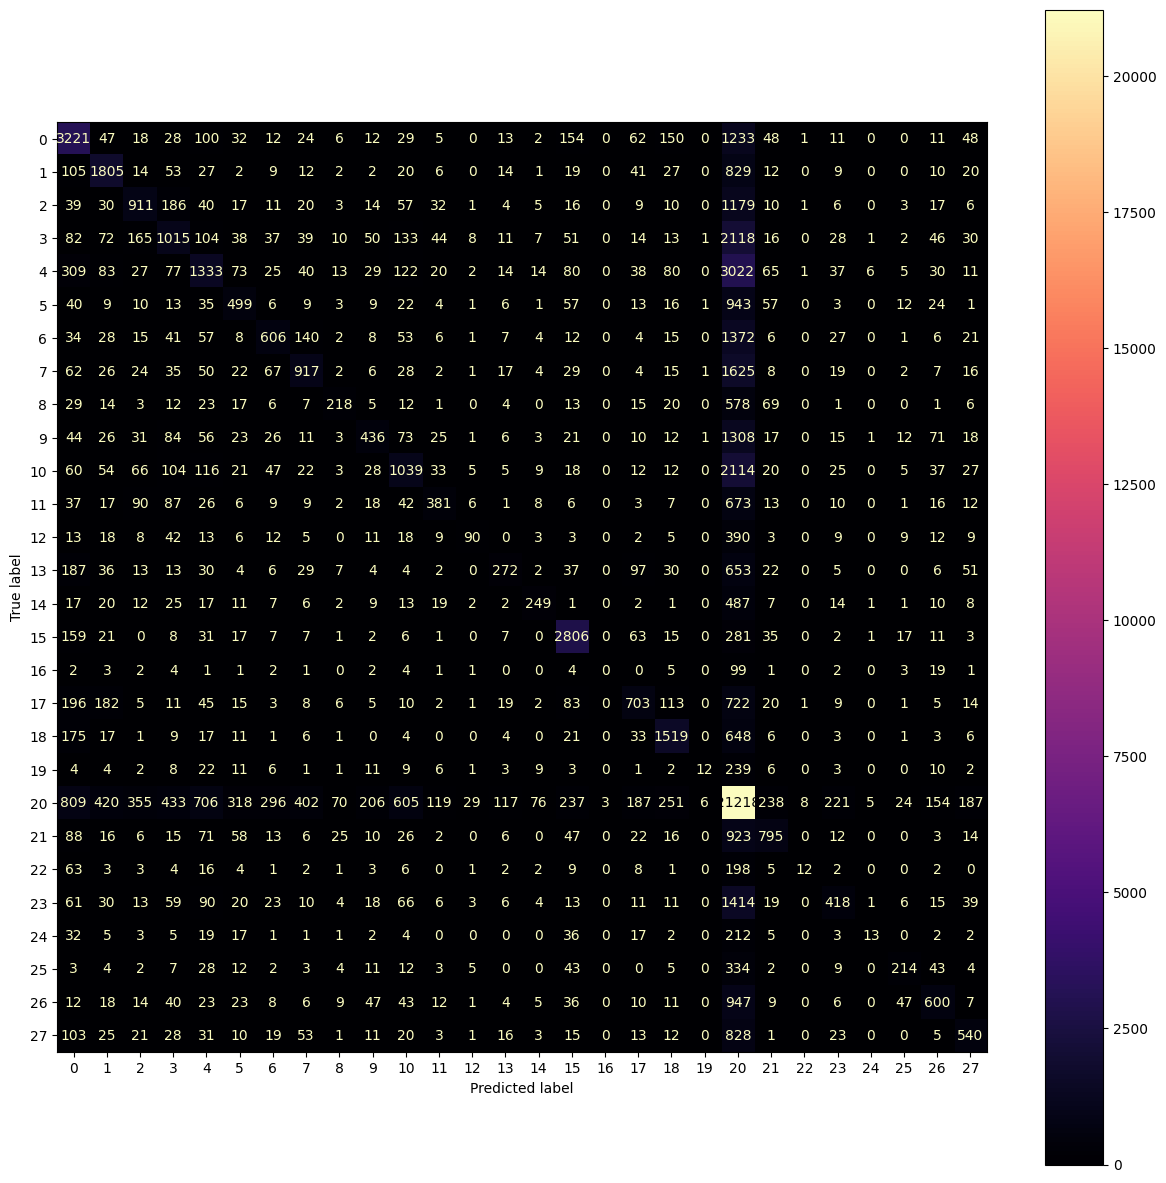

In [258]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): MultinomialNB(alpha=1), Best Score: 0.543696292227927
Accuracy for Emotion: 0.6149109533232453
Precision (Weighted) for Emotion: 0.6098777888671919
F1 Score (Weighted) for Emotion: 0.6088927778965006
F1 Score (Macro) for Emotion: 0.5774810988989699
              precision    recall  f1-score   support

           0       0.55      0.35      0.42      9605
           1       0.61      0.61      0.61     19313
           2       0.57      0.57      0.57     27700
           3       0.66      0.75      0.70     29292

    accuracy                           0.61     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.61      0.61     85910



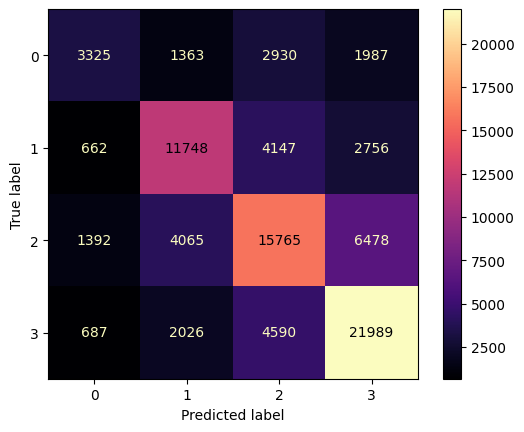

In [259]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>DecisionTree Classifier found using GridSearchCV and new test train split </h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples

In [260]:
parameters = {"criterion": ("gini", "entropy"), "max_depth": (100, 3), "min_samples_split": (12, 5, 30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/DT1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.3984285880572692
Accuracy for Emotion: 0.4700966127342568
Precision (Weighted) for Emotion: 0.45955732804262633
F1 Score (Weighted) for Emotion: 0.42438280679961976
F1 Score (Macro) for Emotion: 0.32193581254455145
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      5267
           1       0.57      0.58      0.58      3039
           2       0.44      0.27      0.33      2627
           3       0.30      0.16      0.21      4135
           4       0.33      0.15      0.20      5556
           5       0.34      0.14      0.20      1794
           6       0.42      0.21      0.28      2474
           7       0.46      0.22      0.30      2989
           8       0.41      0.25      0.31      1054
           9       0.35      0.14      0.20      2334
          10       0.34      0.15      0.21      3882
          11       0.43      0.20  

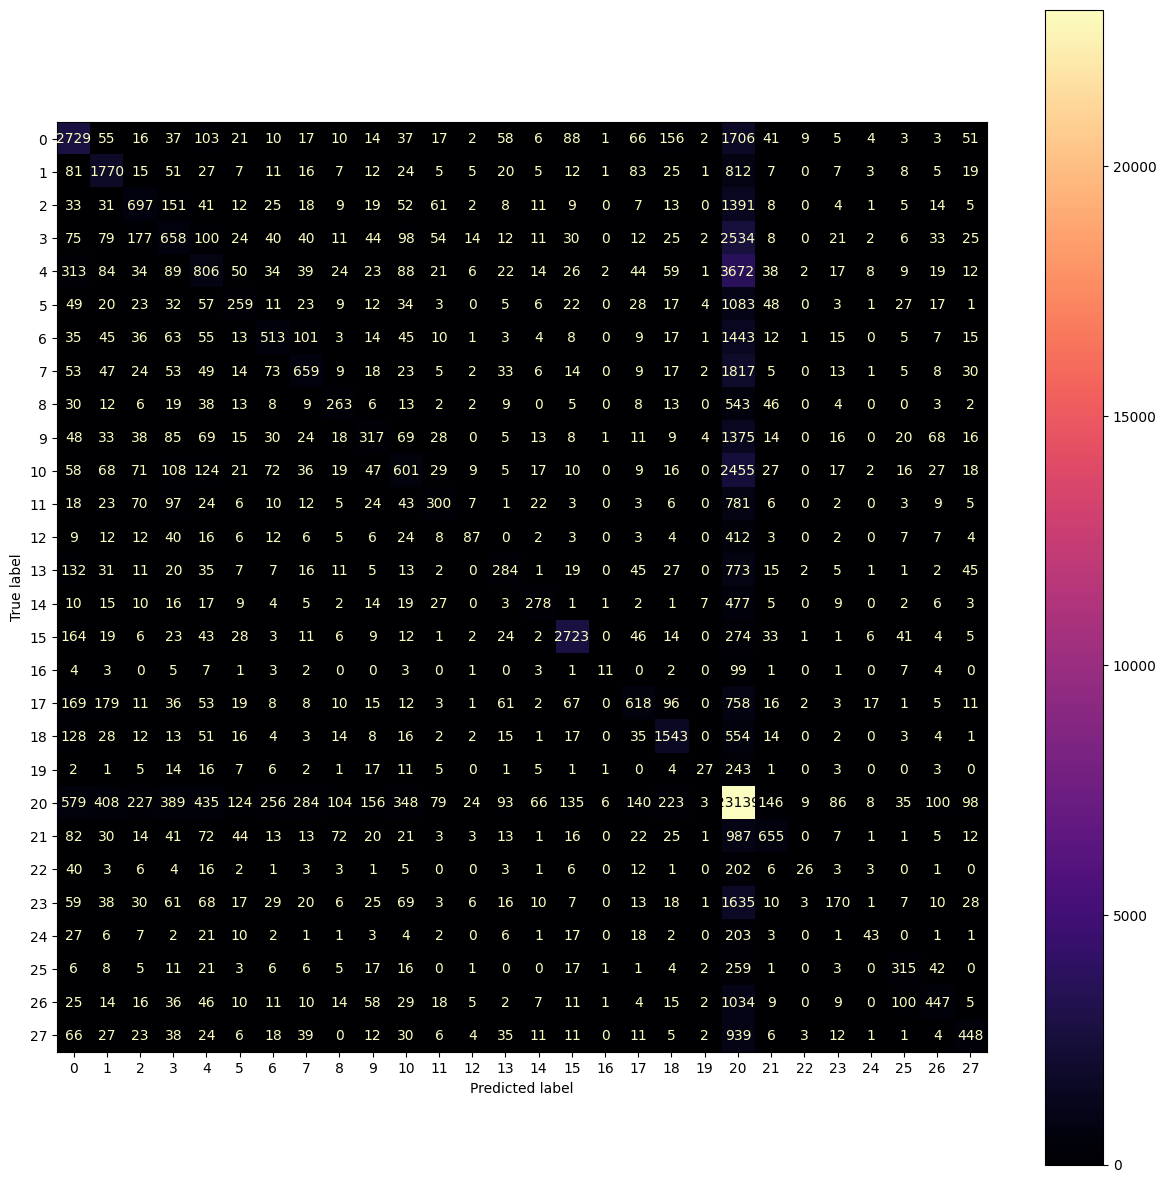

In [261]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.49976719823070653
Accuracy for Emotion: 0.5848446048189966
Precision (Weighted) for Emotion: 0.6300769602522396
F1 Score (Weighted) for Emotion: 0.5830137608313267
F1 Score (Macro) for Emotion: 0.5507841678078954
              precision    recall  f1-score   support

           0       0.52      0.35      0.42      9605
           1       0.65      0.45      0.53     19313
           2       0.48      0.78      0.59     27700
           3       0.80      0.57      0.66     29292

    accuracy                           0.58     85910
   macro avg       0.61      0.54      0.55     85910
weighted avg       0.63      0.58      0.58     85910



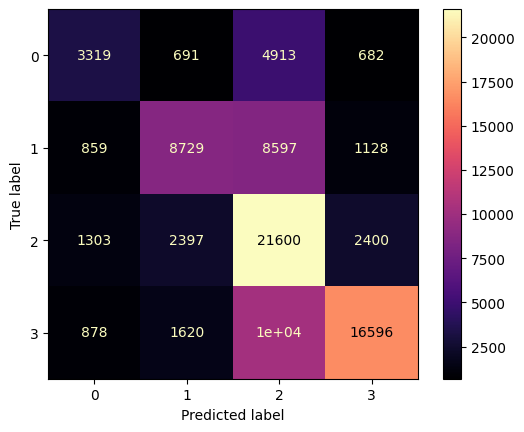

In [262]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [263]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd"),"max_iter":(5,50,100)}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier()
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters)
skip=True
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/new_split/MLP2GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

skipped


In [264]:
if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

skipped


In [265]:
if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

skipped


<h3>3. Embedding as features</h3>

requires install of library gensim

pip install gensim

https://radimrehurek.com/gensim/models/word2vec.html


In [266]:
# result.most_similar("cat")

In [267]:
if (os.path.exists('models/word2vec.pickle')):
    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)
    print("pickle file used")
else:
    model =gensim.downloader.load("word2vec-google-news-300")
    with open('models/word2vec.pickle','wb') as f:
        pickle.dump(model, f)

    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)

pickle file used


In [268]:
nltk.download('punkt')
post.str.lower()
tokenized_word = [word_tokenize(i) for i in post]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chanj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [269]:
post_tokens = [post_tokens for post_tokens in tokenized_word] #http://librarycarpentry.org/lc-tdm/aio/index.html
print("Number of tokens in Reddit posts:")
tokens_list = []
for i in post_tokens:
    for j in i:
        tokens_list.append(j)
print(len(tokens_list))

Number of tokens in Reddit posts:
2642128


In [270]:
average_embedding = []
key_error = False
missed = 0
for post in post_tokens:
    token_embeddings = []
    for words in post:
        key_error = False
        try:
            token_embeddings.append(model.wv[words])
        except KeyError:
            key_error = True
            missed = missed + 1
    if(not key_error):
        average_embedding.append(np.mean(token_embeddings,axis=0))
print(1 - (missed/len(tokens_list)))

1.0
